In [1]:
import numpy as np   
import pandas as pd  
import os
import gc
import seaborn as sns  # for plotting graphs
import matplotlib.pyplot as plt # for plotting graphs aswell
import glob
from datetime import datetime
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import coo_matrix, hstack
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
%matplotlib inline


In [2]:
# to display maximum rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [3]:
# function to set all numerical data to int16 or float16, to save on memory use
def dtype_conver(Dataframe):
    for col in Dataframe:
        if Dataframe[col].dtype in ['float32','float64']:
            Dataframe[col] = Dataframe[col].astype(np.float16)
        if Dataframe[col].dtype in ['int32','float64']:
            Dataframe[col] = Dataframe[col].astype(np.int16)

In [4]:
#Parameters for lightGBM classification
model_lgb = LGBMClassifier(
        n_jobs=4,
        n_estimators=100000,
        boost_from_average='false',
        learning_rate=0.02,
        num_leaves=64,
        num_threads=4,
        max_depth=7,
        tree_learner = "serial",
        feature_fraction = 0.7,
        bagging_freq = 5,
        bagging_fraction = 0.5,
#         min_data_in_leaf = 75,
#         min_sum_hessian_in_leaf = 50.0,
        silent=-1,
        verbose=-1,
        device='cpu',
        )

In [5]:
#Parameters for RFC classification
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)

In [6]:
# import OneHotEncoder & define it
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories = 'auto',sparse=True)

In [7]:
kf = KFold(n_splits=5, random_state=10, shuffle=True)

In [8]:

def master_pipe(X_ohe,y):

  # place holder for k-fold scores
    scores = []

  # to differentiate files names produced by plt.savefig
    n = 1

  # model pipeline calculates model score and saves feature importance graph as .png file
    for i,(tr_idx, val_idx) in enumerate(kf.split(X_ohe,y)):
        print('Fold :{}'.format(i))
        tr_X = X_ohe[tr_idx]  # training for this loop
        tr_y = y[tr_idx] #
        val_X = X_ohe[val_idx]# validation data for this loop
        val_y = y[val_idx]
        # here build your models
        model = model_lgb
        model.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y), (val_X, val_y)], eval_metric = 'auc', verbose=100, 
                  early_stopping_rounds= 50)
        #picking best model?
        pred_val_y = model.predict_proba(val_X,num_iteration=model.best_iteration_)[:,1]
        #measuring model vs validation
        score = roc_auc_score(val_y,pred_val_y)
        scores.append(score)
        print('current performance by auc:{}'.format(score))
        lightgbm.plot_importance(model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', 
                                 xlabel='Feature importance', ylabel='Features', importance_type='split',
                                 max_num_features=20, ignore_zero=True, figsize=None, grid=True, precision=3)
        # in python plots dir will be auto-created
        plt.show()
        #plt.savefig('..(in jupyter, point destination here and remove plots dir ->)plots/feature_importance{}.png'.format(n))
        plt.close()
        n=n+1

In [47]:
def master_pipe_RFC(X_ohe,y):
    # place holder for k-fold scores
    scores_rfc = []

  # model pipeline calculates model score and saves feature importance graph as .png file
    for i,(tr_idx, val_idx) in enumerate(kf.split(X_ohe,y)):
        print('Fold :{}'.format(i))
        tr_X = X_ohe[tr_idx]  # training for this loop
        tr_y = y[tr_idx] #
        val_X = X_ohe[val_idx]# validation data for this loop
        val_y = y[val_idx]
        # here build your models
        model = clf
        model.fit(tr_X, tr_y)
        #picking best model?
        pred_val_y = model.predict(val_X)
        #measuring model vs validation
        score_rfc = roc_auc_score(val_y,pred_val_y)
        scores_rfc.append(score_rfc)
        print('current performance by auc:{}'.format(score_rfc))
        

In [10]:
# Read in filepath  
DATA_PATH = r'C:/Users/t891199/Desktop/Big_Data_Diploma/CEBD_1260_Machine_learning/Data Files/Class_3/'
file_name = os.path.join(DATA_PATH,'train.csv')


In [11]:
# pandas reads in csv file using filepath
old_train_df = pd.read_csv(file_name)
print(old_train_df.shape)
#original_quote_date is time-series

(260753, 299)


In [12]:
#Feature Engineering
old_train_df['Original_Quote_Date'] = pd.to_datetime(old_train_df['Original_Quote_Date'])
old_train_df['year'] = old_train_df['Original_Quote_Date'].dt.year
old_train_df['month'] = old_train_df['Original_Quote_Date'].dt.month
old_train_df['day'] = old_train_df['Original_Quote_Date'].dt.day
train_df = old_train_df.drop(["Original_Quote_Date"], axis = 1)

In [13]:
# lets see how many NaN or Null values are in each column
nan_info = pd.DataFrame(train_df.isnull().sum()).reset_index()
nan_info.columns = ['col','nan_cnt']


In [14]:
#sort them in descending order and print 1st 10
nan_info.sort_values(by = 'nan_cnt',ascending=False,inplace=True)
nan_info.head(10)

,col,nan_cnt
160,PropertyField29,200685
124,PersonalField84,124208
169,PropertyField38,1220
167,PropertyField36,113
48,PersonalField7,113
129,PropertyField3,81
163,PropertyField32,70
165,PropertyField34,70
130,PropertyField4,63
198,GeographicField14A,0


In [15]:
# extract column names with NaNs and Nulls
# in numerical cols
num_cols_with_missing = ['PersonalField84','PropertyField29']



In [16]:
# extract column names with NaNs and Nulls
# in boolean type cols
bool_cols_with_missing = ['PropertyField3','PropertyField4','PersonalField7','PropertyField32',
                          'PropertyField34','PropertyField36','PropertyField38']


In [17]:
# fill in null and NaN values with 'U' in boolean type cols ( 'Y','N')
for cols in bool_cols_with_missing:
    train_df[cols].fillna('U',inplace=True)



In [18]:
# fill in null and NaN values with -1 in numerical missing values
for cols in num_cols_with_missing:
    train_df[cols].fillna(-1, inplace=True)


In [19]:
# define target
y = old_train_df["QuoteConversion_Flag"].values

In [20]:
# drop target column from data
# and static columns GeographicField10A & PropertyField6
X = train_df.drop(["QuoteConversion_Flag","GeographicField10A","PropertyField6"], axis = 1)


In [21]:
#QuoteNumber setting as index
X = X.set_index("QuoteNumber")

In [22]:
dtype_conver(X)

In [23]:
# select all columns that are categorical i.e with unique categories less than 40 in our case
X_for_ohe = [cols for cols in X.columns if X[cols].nunique() < 40 or X[cols].dtype in['object']]
X_not_ohe = [cols for cols in X.columns if X[cols].nunique() > 40 and X[cols].dtype not in['object']]


In [24]:
#numerical column that we will not encode
X[X_not_ohe].head()


,SalesField8
QuoteNumber,
1,48649
2,26778
4,8751
6,43854
8,12505


In [25]:
#to keep track of our columns, how many are remaining after we removed 4 so far?
len(X_for_ohe)

296

In [26]:
X['SalesField8'].head()

QuoteNumber
1    48649
2    26778
4     8751
6    43854
8    12505
Name: SalesField8, dtype: int64

In [27]:
nan_info = pd.DataFrame(X[X_for_ohe].isnull().sum()).reset_index()
nan_info.columns = ['col','nan_cnt']

In [28]:
#sort them in descending order and print 1st 10
nan_info.sort_values(by = 'nan_cnt',ascending=False,inplace=True)
nan_info.head(10)

,col,nan_cnt
0,Field6,0
203,GeographicField19A,0
201,GeographicField18A,0
200,GeographicField17B,0
199,GeographicField17A,0
198,GeographicField16B,0
197,GeographicField16A,0
196,GeographicField15B,0
195,GeographicField15A,0
194,GeographicField14B,0


In [29]:
# apply OneHotEncoder on categorical feature columns
X_ohe = ohe.fit_transform(X[X_for_ohe])


In [30]:
# we are pretty much done for now here, apparently we can set 'sparse = True' in OneHotEncoder and we get a 
#csr_matrix. I left it as false so that you can see the sparse matrix
X_ohe


<260753x5053 sparse matrix of type '<class 'numpy.float64'>'
	with 77182888 stored elements in Compressed Sparse Row format>

In [31]:
# SalesField8 was kept out of sparse matrix, now we need to bring it back
# scaledown SalesField8 for easy handling using log(), then convert to float16
SF8 = np.log(X['SalesField8']).astype(np.float16)
hstack((X_ohe,np.array(SF8)[:,None]))

<260753x5054 sparse matrix of type '<class 'numpy.float64'>'
	with 77443640 stored elements in COOrdinate format>

In [48]:
# lets get the model k-fold scores for RFC
master_pipe_RFC(X_ohe,y)

Fold :0
current performance by auc:0.5
Fold :1
current performance by auc:0.5
Fold :2
current performance by auc:0.5
Fold :3
current performance by auc:0.5
Fold :4
current performance by auc:0.5


Fold :0
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.956316	training's binary_logloss: 0.237383	valid_1's auc: 0.954839	valid_1's binary_logloss: 0.236975
[200]	training's auc: 0.960422	training's binary_logloss: 0.190373	valid_1's auc: 0.958327	valid_1's binary_logloss: 0.191157
[300]	training's auc: 0.963752	training's binary_logloss: 0.178257	valid_1's auc: 0.960374	valid_1's binary_logloss: 0.181383
[400]	training's auc: 0.966979	training's binary_logloss: 0.170736	valid_1's auc: 0.961703	valid_1's binary_logloss: 0.17723
[500]	training's auc: 0.969755	training's binary_logloss: 0.164646	valid_1's auc: 0.962475	valid_1's binary_logloss: 0.174834
[600]	training's auc: 0.972186	training's binary_logloss: 0.159703	valid_1's auc: 0.963093	valid_1's binary_logloss: 0.173345
[700]	training's auc: 0.974324	training's binary_logloss: 0.155456	valid_1's auc: 0.963332	valid_1's binary_logloss: 0.172668
[800]	training's auc: 0.97621	training's binary_lo

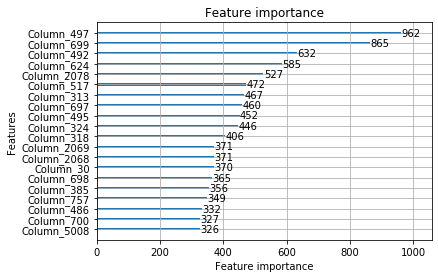

Fold :1
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.956787	training's binary_logloss: 0.236433	valid_1's auc: 0.954975	valid_1's binary_logloss: 0.23952
[200]	training's auc: 0.960195	training's binary_logloss: 0.189756	valid_1's auc: 0.957909	valid_1's binary_logloss: 0.194508
[300]	training's auc: 0.963693	training's binary_logloss: 0.177654	valid_1's auc: 0.960228	valid_1's binary_logloss: 0.1845
[400]	training's auc: 0.96727	training's binary_logloss: 0.169332	valid_1's auc: 0.961757	valid_1's binary_logloss: 0.179632
[500]	training's auc: 0.970032	training's binary_logloss: 0.163839	valid_1's auc: 0.962479	valid_1's binary_logloss: 0.177682
[600]	training's auc: 0.972368	training's binary_logloss: 0.158997	valid_1's auc: 0.962984	valid_1's binary_logloss: 0.176186
[700]	training's auc: 0.974427	training's binary_logloss: 0.154496	valid_1's auc: 0.96327	valid_1's binary_logloss: 0.175187
[800]	training's auc: 0.976258	training's binary_loglo

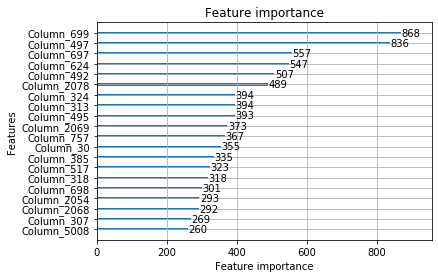

Fold :2
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.95596	training's binary_logloss: 0.23746	valid_1's auc: 0.957376	valid_1's binary_logloss: 0.235553
[200]	training's auc: 0.959716	training's binary_logloss: 0.191081	valid_1's auc: 0.960138	valid_1's binary_logloss: 0.19015
[300]	training's auc: 0.963305	training's binary_logloss: 0.178788	valid_1's auc: 0.962369	valid_1's binary_logloss: 0.179984
[400]	training's auc: 0.966661	training's binary_logloss: 0.170963	valid_1's auc: 0.963659	valid_1's binary_logloss: 0.17547
[500]	training's auc: 0.969523	training's binary_logloss: 0.164948	valid_1's auc: 0.964495	valid_1's binary_logloss: 0.172978
[600]	training's auc: 0.971897	training's binary_logloss: 0.16016	valid_1's auc: 0.964893	valid_1's binary_logloss: 0.171676
[700]	training's auc: 0.974049	training's binary_logloss: 0.15584	valid_1's auc: 0.965166	valid_1's binary_logloss: 0.170832
[800]	training's auc: 0.975952	training's binary_loglos

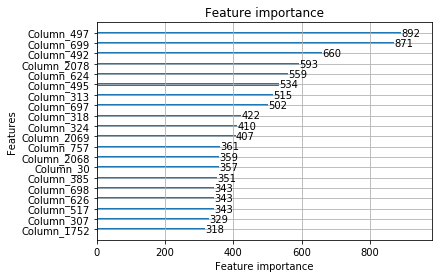

Fold :3
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.9564	training's binary_logloss: 0.236131	valid_1's auc: 0.954781	valid_1's binary_logloss: 0.237637
[200]	training's auc: 0.96013	training's binary_logloss: 0.189644	valid_1's auc: 0.958343	valid_1's binary_logloss: 0.192522
[300]	training's auc: 0.963766	training's binary_logloss: 0.177375	valid_1's auc: 0.960868	valid_1's binary_logloss: 0.182476
[400]	training's auc: 0.967189	training's binary_logloss: 0.169643	valid_1's auc: 0.962357	valid_1's binary_logloss: 0.178163
[500]	training's auc: 0.969908	training's binary_logloss: 0.164047	valid_1's auc: 0.963105	valid_1's binary_logloss: 0.176131
[600]	training's auc: 0.97231	training's binary_logloss: 0.159201	valid_1's auc: 0.963558	valid_1's binary_logloss: 0.174807
[700]	training's auc: 0.974368	training's binary_logloss: 0.154961	valid_1's auc: 0.963798	valid_1's binary_logloss: 0.174101
[800]	training's auc: 0.976331	training's binary_logl

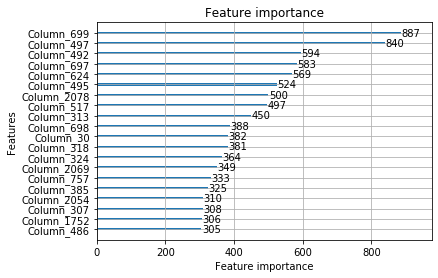

Fold :4
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.956349	training's binary_logloss: 0.236958	valid_1's auc: 0.956362	valid_1's binary_logloss: 0.237872
[200]	training's auc: 0.959982	training's binary_logloss: 0.190128	valid_1's auc: 0.959523	valid_1's binary_logloss: 0.192003
[300]	training's auc: 0.963474	training's binary_logloss: 0.177986	valid_1's auc: 0.961746	valid_1's binary_logloss: 0.181654
[400]	training's auc: 0.966943	training's binary_logloss: 0.170278	valid_1's auc: 0.963141	valid_1's binary_logloss: 0.177354
[500]	training's auc: 0.96981	training's binary_logloss: 0.164279	valid_1's auc: 0.963934	valid_1's binary_logloss: 0.174908
[600]	training's auc: 0.972229	training's binary_logloss: 0.159343	valid_1's auc: 0.964371	valid_1's binary_logloss: 0.173506
[700]	training's auc: 0.974281	training's binary_logloss: 0.15508	valid_1's auc: 0.964669	valid_1's binary_logloss: 0.172549
[800]	training's auc: 0.976279	training's binary_lo

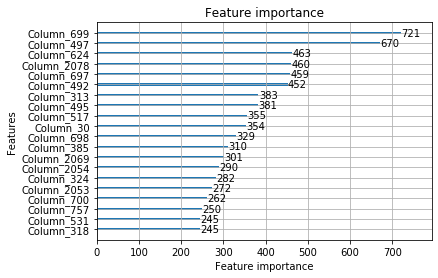

In [54]:
# lets get the model k-fold scores and print feature importance graphs
master_pipe(X_ohe,y)
